# Kalman filter strat
Basically attempting to implement this: https://www.reddit.com/r/algotrading/comments/obbb5d/kalman_filter_stat_arb/

With help from: 
https://github.com/welly87/epchanbooks/blob/main/book2/KF_beta_EWA_EWC.py

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
from IPython.display import clear_output

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

In [3]:
# FETUSDT CELRUSDT 13000 ~150

# WINUSDT WRXUSDT 162 ~150                 X
# GTOUSDT MITHUSDT 304, ~500               300   √
# DREPUSDT WINUSDT 26000, ~500             X
# ARDRUSDT WANUSDT 470, ~200 but very low volume   188
# CTXCUSDT WTCUSDT 420, ~500, but very low volume  229...
# COSUSDT TROYUSDT 220, ~500,
# BTSUSDT CTXCUSDT 290, ~500,
# AIONUSDT LSKUSDT 310, ~300, but very low volume
# NPXSUSDT ONEUSDT 400, ~2000 very risky
# MITHUSDT NKNUSDT 380, ~500
# NKNUSDT WRXUSDT 40, but up recently, ~200


In [4]:
df1 = pd.read_csv("../data/testing-hourly/CELRUSDT-minute.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv("../data/testing-hourly/FETUSDT-minute.csv", index_col=0, parse_dates=True)

# df1 = pd.read_csv("../data/testing-hourly/NKNUSDT-hour.csv", index_col=0, parse_dates=True)
# df2 = pd.read_csv("../data/testing-hourly/WRXUSDT-hour.csv", index_col=0, parse_dates=True)

# df1 = pd.read_csv("../data/CELRUSDT-past.csv", index_col=0, parse_dates=True)
# df2 = pd.read_csv("../data/FETUSDT-past.csv", index_col=0, parse_dates=True)

# df1 = pd.read_csv("../data/testing-hourly/BTTUSDT-minute.csv", index_col=0, parse_dates=True)
# df2 = pd.read_csv("../data/testing-hourly/HOTUSDT-minute.csv", index_col=0, parse_dates=True)

# df1 = pd.read_csv("../data/ZECUSDT-minute.csv", index_col=0, parse_dates=True)
# df2 = pd.read_csv("../data/XMRUSDT-minute.csv", index_col=0, parse_dates=True)

In [5]:
print(len(df1))
print(len(df2))

1212637
1247928


In [6]:
df = df1.open.rename("A").to_frame()
df["B"] = df2.open
# df["C"] = df3.close

In [7]:
df = df[1000:]
df = df.dropna()

In [19]:
# fig, (ax, ax1) = plt.subplots(2, figsize=(12, 8))
# ax.plot(df[df.columns[0]], color="lightblue", alpha=.95)
# axi = ax.twinx()
# axi.plot(df[df.columns[1]], color="orange", alpha=.75)
# ax1.scatter(df[df.columns[0]], df[df.columns[1]]);

### Standard

In [78]:
results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
hedgeRatio = results.params[1]
print('hedgeRatio=%f' % hedgeRatio)

hedgeRatio=8.966777


In [79]:
spread = pd.Series((df['B'] - hedgeRatio * df['A'])).rename("spread").to_frame()
spread["mean"] = spread.spread.rolling(4000).mean()
spread["std"] =  spread.spread.rolling(4000).std()
spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])

# spread.spread.plot()

### Lookback period

In [8]:
lookback = 200000
ds = 100 #downsample
hedgeRatio = np.full(df.shape[0], np.nan)
l = math.floor(len(hedgeRatio[:-lookback])/ds)
index = []
for t in np.arange(l):
    clear_output()
    print(f"{t} < {l}")
    regress_results = sm.ols(formula="B ~ A",
                             data=df[t*ds:t*ds+lookback]).fit()  # Note this can deal with NaN in top row
    hedgeRatio[t] = regress_results.params[1]
    index.append(df.index[t*ds+lookback])

10115 < 10116


In [119]:
hr = pd.Series(hedgeRatio).dropna().rename("hr").to_frame()

hr["index"] = index
hr.set_index("index", inplace=True)

In [120]:
spread = pd.DataFrame(hr.hr, index=df.index)
# spread = pd.DataFrame(list(hr), index=df.index, columns=["hr"])

In [121]:
spread.ffill(inplace=True)

In [122]:
spread = pd.Series((df['B'] - spread["hr"] * df['A'])).rename("spread").to_frame()
spread["mean"] = spread.spread.rolling(4000).mean()
spread["std"] =  spread.spread.rolling(4000).std()
spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])

### Kalman filter lookback period

### Continue

In [123]:
spread = spread.dropna()

In [124]:
spread["A"] = df1["close"].reindex(spread.index)
spread["Ah"] = df1["high"].reindex(spread.index)
spread["Al"] = df1["low"].reindex(spread.index)

spread["B"] = df2["close"].reindex(spread.index)
spread["Bh"] = df2["high"].reindex(spread.index)
spread["Bl"] = df2["low"].reindex(spread.index)

# spread.index = (range(len(spread))) #If using XXXUSDT-past.csv

### Bollinger band thres + sell_thres

In [125]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return np.round(upband,5), np.round(dnband,5)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return np.round(upband,5), -np.round(dnband,5)

In [126]:
window=100000
numsd=1
spread['thres'],spread['sell_thres']=bbands(spread.zscore, window=window, numsd=numsd)
spread.dropna(inplace=True)

In [127]:
spread["sell_thres"] = 0

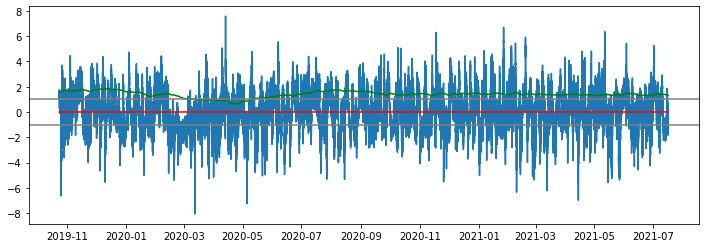

In [128]:
fig, ax = plt.subplots(figsize=(12, 4))


ax.plot(spread.zscore)
ax.plot(spread.thres, color="green")
ax.plot(-spread.sell_thres, color="red")
ax.axhline(y=1, color="gray")
ax.axhline(y=-1, color="gray")

### Scaling-in thres and sell_thres

### Continue

In [129]:
spread.tail(5)

,spread,mean,std,zscore,A,Ah,Al,B,Bh,Bl,thres,sell_thres
timestamp,,,,,,,,,,,,
2021-07-16 12:52:00,0.005923,0.009215,0.003985,-0.826113,0.02321,0.02323,0.02320,0.20654,0.20689,0.20649,1.32023,0
2021-07-16 12:53:00,0.005524,0.009216,0.003984,-0.926603,0.02345,0.02345,0.02323,0.20795,0.20850,0.20655,1.32022,0
2021-07-16 12:54:00,0.004886,0.009216,0.003984,-1.086593,0.02338,0.02344,0.02338,0.20825,0.20866,0.20773,1.32022,0
2021-07-16 12:55:00,0.005722,0.009216,0.003984,-0.876882,0.02338,0.02340,0.02337,0.20924,0.20932,0.20803,1.32021,0
2021-07-16 12:56:00,0.006496,0.009217,0.003984,-0.682868,0.02356,0.02356,0.02344,0.21125,0.21125,0.20922,1.32021,0


In [130]:
def get_a_b(al, ac, ah, bl, bc, bh):
    return ac-abs(ac-al)/2, ac+abs(ac-ah)/2, bc-abs(bc-bl)/2, bc+abs(bc-bh)/2

In [131]:
fee = 0.003       #Set double normal rate
thres = 1.        #2
sell_thres = 1.   # 0, in range [0, ...) for more travel

In [413]:
# Variable thres and sell_thres from spread.thres and spread.sell_thres
total = 100.
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
trades = 0
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    thres = spread.thres[i]
    sell_thres = spread.sell_thres[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z>thres: 
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
            elif z<-thres:
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
    if long == "B" and z>sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "A" and z<-sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

In [149]:
# Above + Max drawdown + Max drawdown length
total = 100.
p_total = 100. #Previous total
dd_indices = [] #Drawdown indicies
dd_i = True #Ignore
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
max_dr = 0
max_df_length = 0
trades = 0
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    thres = spread.thres[i]
    sell_thres = spread.sell_thres[i]
    al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            if z>thres: 
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
            elif z<-thres:
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
    if long == "B" and z>sell_thres: #Liquidate positions
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "A" and z<-sell_thres: #Liquidate positions
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    if long == "B":
        dd = 0.5*(price_a[0] - ah)/price_a[0]
        dd += 0.5*(bl - price_b[0])/price_b[0]
        max_dr = dd if max_dr > dd else max_dr
    elif long == "A":
        dd = 0.5*(al - price_a[0])/price_a[0]
        dd += 0.5*(price_b[0] - bh)/price_b[0]
        max_dr = dd if max_dr > dd else max_dr
        
    if total < p_total:
        if dd_i:
            dd_indices.append(spread.index[i])
            dd_i = False
    else:
        if not dd_i:
            dd_indices.append(spread.index[i])
            dd_i = True
        p_total = total
    
    cusum.append(total)

In [184]:
# Buy  random value between high and low, now correct LONG A or B
total = 100.
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
trades = 0
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z>thres: 
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
            elif z<-thres:
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
    if long == "B" and z>sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "A" and z<-sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

In [347]:
# Buy liquidate after 1 days no matter what
total = 100.
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
vb = None
prevent = None
trades = 0
mr = -1           #or 1 for not mean reversion
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z>thres and prevent != "B": 
                vb = spread.index[i] + timedelta(1)
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
                prevent = None
            elif z<-thres and prevent != "A":
                vb = spread.index[i] + timedelta(1)
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
                prevent = None
    if (long == "A" and z>sell_thres) or (long=="A" and spread.index[i]>vb): #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
        if vb:
            prevent = "A"
            vb = None
    elif (long == "B" and z<-sell_thres) or (long=="B" and spread.index[i]>vb): #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
        if vb: 
            prevent = "B"
            vb = None
    cusum.append(total)

In [42]:
# CONSTANT TOTAL
total = 100.
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
trades = 0
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z>thres: 
                price_a = [ah, ((50/2)/ah)*(1.-fee)]
                price_b = [bl, ((50/2)/bl)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
            elif z<-thres:
                price_a = [al, ((50/2)/al)*(1.-fee)]
                price_b = [bh, ((50/2)/bh)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
    if long == "B" and z>sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "A" and z<-sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

In [429]:
# REVERSE!
total = 100.
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
trades = 0
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z<-thres: 
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
            elif z>thres:
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
    if long == "B" and z<-sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "A" and z>sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

In [646]:
# False results for hourly representation
total = 100.
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
trades = 0
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = spread.A[i], spread.A[i], spread.B[i], spread.B[i]
            if z>thres: 
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
            elif z<-thres:
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
    if long == "B" and z>sell_thres: #Liquidate positions
        al, ah, bl, bh = spread.A[i], spread.A[i], spread.B[i], spread.B[i]
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "A" and z<-sell_thres: #Liquidate positions
        al, ah, bl, bh = spread.A[i], spread.A[i], spread.B[i], spread.B[i]
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

In [22]:
# a = df1[1_000_000:]
# a = abs(a.low-a.close)/a.close

22076.452109724825


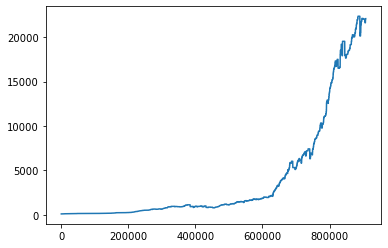

In [150]:
plt.plot(cusum);
print(total)

In [151]:
max_dr

-0.35701243455639275

In [183]:
a = dd_indices[1::2]
b = dd_indices[::2]

In [187]:
a = np.array(a)
b = np.array(b[:len(a)])
c = a-b

In [192]:
c.sort()
c[::-1]

array([Timedelta('65 days 20:06:00'), Timedelta('17 days 21:01:00'),
       Timedelta('13 days 14:27:00'), Timedelta('12 days 19:40:00'),
       Timedelta('11 days 01:27:00'), Timedelta('10 days 08:20:00'),
       Timedelta('8 days 18:27:00'), Timedelta('8 days 03:10:00'),
       Timedelta('7 days 16:20:00'), Timedelta('7 days 15:58:00'),
       Timedelta('7 days 05:20:00'), Timedelta('5 days 10:54:00'),
       Timedelta('5 days 10:47:00'), Timedelta('5 days 05:52:00'),
       Timedelta('4 days 23:28:00'), Timedelta('4 days 17:22:00'),
       Timedelta('4 days 13:08:00'), Timedelta('4 days 04:42:00'),
       Timedelta('3 days 15:02:00'), Timedelta('3 days 13:33:00'),
       Timedelta('3 days 12:56:00'), Timedelta('3 days 12:22:00'),
       Timedelta('3 days 09:50:00'), Timedelta('3 days 00:57:00'),
       Timedelta('2 days 20:21:00'), Timedelta('2 days 14:45:00'),
       Timedelta('2 days 10:55:00'), Timedelta('2 days 08:22:00'),
       Timedelta('2 days 08:12:00'), Timedelta('2 days 0

In [190]:
c

array([Timedelta('0 days 00:02:00'), Timedelta('0 days 00:25:00'),
       Timedelta('0 days 00:33:00'), Timedelta('0 days 00:41:00'),
       Timedelta('0 days 00:50:00'), Timedelta('0 days 00:50:00'),
       Timedelta('0 days 00:56:00'), Timedelta('0 days 01:16:00'),
       Timedelta('0 days 01:46:00'), Timedelta('0 days 01:59:00'),
       Timedelta('0 days 02:00:00'), Timedelta('0 days 02:01:00'),
       Timedelta('0 days 02:23:00'), Timedelta('0 days 02:25:00'),
       Timedelta('0 days 03:18:00'), Timedelta('0 days 03:50:00'),
       Timedelta('0 days 04:22:00'), Timedelta('0 days 04:37:00'),
       Timedelta('0 days 08:05:00'), Timedelta('0 days 08:47:00'),
       Timedelta('0 days 10:36:00'), Timedelta('0 days 10:41:00'),
       Timedelta('0 days 10:49:00'), Timedelta('0 days 11:19:00'),
       Timedelta('0 days 12:23:00'), Timedelta('0 days 14:24:00'),
       Timedelta('0 days 18:42:00'), Timedelta('0 days 18:51:00'),
       Timedelta('0 days 19:16:00'), Timedelta('0 days 19:42:0

## Plotting

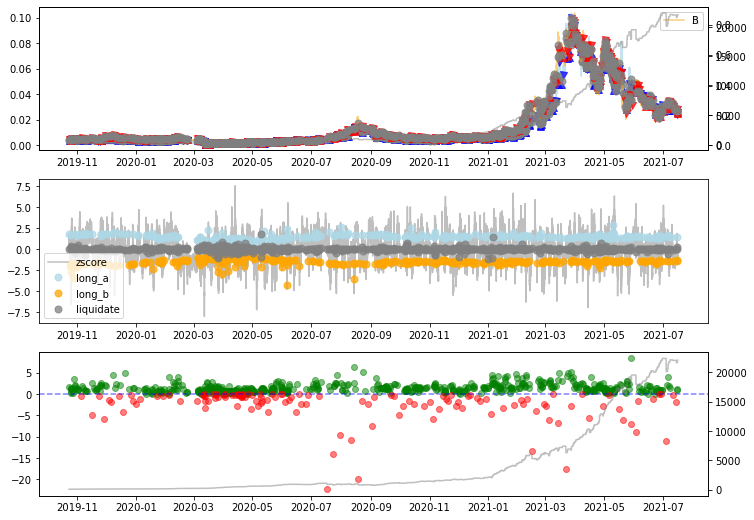

In [134]:
plot = spread
plot["cusum"] = cusum

s = list(pd.Series(cusum).diff())
s = pd.Series(s, index=spread.index)
plot["diffs"] = s[s != 0.]


plot = plot[:] #500_000:700_000

fig, (ax, axz, axc) = plt.subplots(3, figsize=(12,9))

# close_df.loc['2014':].plot(ax=ax, alpha=.5)
ax.plot(plot.A, alpha=.7, color="lightblue", label="A")
ax1 = ax.twinx()
ax1.plot(plot.B, alpha=.5, color="orange", label="B")


ax.plot(plot.A.reindex(long_a), marker='^', markersize=7,
                     alpha=0.75, color='blue', linewidth=0)

ax.plot(plot.A.reindex(long_b), marker='v', markersize=7,
                     alpha=0.75, color='blue', linewidth=0)

ax1.plot(plot.B.reindex(long_b), marker='^', markersize=7,
                     alpha=0.75, color='red', linewidth=0)

ax1.plot(plot.B.reindex(long_a), marker='v', markersize=7,
                     alpha=0.75, color='red', linewidth=0)
ax.plot(plot.A.reindex(liquidate), marker='o', markersize=7,
                     alpha=0.75, color='gray', linewidth=0)
ax1.plot(plot.B.reindex(liquidate), marker='o', markersize=7,
                     alpha=0.75, color='gray', linewidth=0)
ax2 = ax.twinx()
ax2.plot(plot.cusum, color="gray", alpha=.5)
ax.legend()
ax1.legend()

axz.plot(plot.zscore, color="gray", alpha=.5, label="zscore")
axz.plot(plot.zscore.reindex(long_a), marker='o', markersize=7,
                     alpha=0.75, label='long_a', color='lightblue', linewidth=0)
axz.plot(plot.zscore.reindex(long_b), marker='o', markersize=7,
                     alpha=0.75, label='long_b', color='orange', linewidth=0)
axz.plot(plot.zscore.reindex(liquidate), marker='o', markersize=7,
                     alpha=0.75, label='liquidate', color='gray', linewidth=0)

axz.legend()

axc.scatter(plot.index, plot.diffs[plot.diffs > 0].reindex(plot.index)*100/plot.cusum, color="green", alpha=.5)
axc.scatter(plot.index, plot.diffs[plot.diffs <= 0].reindex(plot.index)*100/plot.cusum, color="red", alpha=.5)
axc.axhline(0, linestyle="--", color="blue", alpha=.5)
axc1 = axc.twinx()
axc1.plot(plot.cusum, color="gray", alpha=.5)

## Creating metalabels

In [128]:
side_up = pd.Series(1, index=long_a)
side_down = pd.Series(-1, index=long_b)
side = pd.concat([side_up,side_down]).sort_index()
side

2019-03-29 04:39:00    1
2019-03-29 07:07:00   -1
2019-03-29 18:25:00    1
2019-03-31 06:51:00   -1
2019-03-31 16:32:00    1
                      ..
2021-07-11 01:26:00   -1
2021-07-12 09:59:00    1
2021-07-12 12:02:00   -1
2021-07-14 09:12:00    1
2021-07-16 00:09:00   -1
Length: 1909, dtype: int64

In [137]:
c_sum = pd.Series(data=cusum, index=spread.index)
c_sum = c_sum.diff()
c_sum = c_sum[c_sum != 0.][1:]
target = c_sum.map(lambda x: 1 if x>0 else 0)

In [141]:
metalabels = side[:-1].rename("side").to_frame()
metalabels["ret"] = list(c_sum)
metalabels["target"] = list(target)

In [143]:
metalabels.to_csv("../data/metalabels.csv")

## Others

In [489]:
# cadf test
coint_t, pvalue, crit_value = ts.coint(df['B'], df['A'])
print('t-statistic=%f' % coint_t)
print('pvalue=%f' % pvalue)
print(crit_value)

KeyboardInterrupt: 

### GOOD CADFs
- ETH-XMR: -3.8
- ZEC-XMR: -3.4
- ETH-ADA: -5

In [490]:
# Johansen test
result = vm.coint_johansen(df[['A', 'B']].values, det_order=0, k_ar_diff=1)
print(result.lr1)
print(result.cvt)
print(result.lr2)
print(result.cvm)

[199.85595738   4.26277077]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[195.59318661   4.26277077]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [102]:
# Add IGE for Johansen test
result = vm.coint_johansen(df.values, det_order=0, k_ar_diff=1)
print(result.lr1)
print(result.cvt)
print(result.lr2)
print(result.cvm)

[29.57270139  2.71300412]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[26.85969727  2.71300412]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [491]:
print(result.eig)  # eigenvalues
print(result.evec)  # eigenvectors

[1.61816728e-04 3.52692355e-06]
[[269.19025662  23.92829479]
 [-29.24700968   3.60031228]]


<AxesSubplot:>

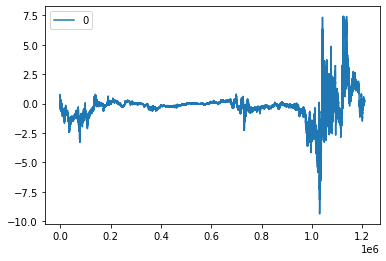

In [492]:
yport = pd.DataFrame(np.dot(df.values, result.evec[:, 0]))  # (net) market value of portfolio
yport.plot()

In [493]:
ylag = yport.shift()
deltaY = yport - ylag
df2 = pd.concat([ylag, deltaY], axis=1)
df2.columns = ['ylag', 'deltaY']
regress_results = sm.ols(formula="deltaY ~ ylag", data=df2).fit()  # Note this can deal with NaN in top row
print(regress_results.params)

Intercept   -0.000092
ylag        -0.000375
dtype: float64


In [494]:
halflife = -np.log(2) / regress_results.params['ylag']
print('halflife=%f days' % halflife)

halflife=1846.180824 days


APR=0.012435 Sharpe=0.436517


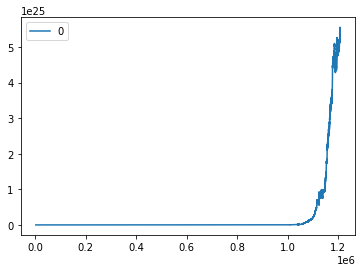

In [495]:
#  Apply a simple linear mean reversion strategy to EWA-EWC-IGE
lookback = np.round(halflife).astype(int)  # setting lookback to the halflife found above
numUnits = -(yport - yport.rolling(lookback).mean()) / yport.rolling(
    lookback).std()  # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
positions = pd.DataFrame(np.dot(numUnits.values, np.expand_dims(result.evec[:, 0],
                                                                axis=1).T) * df.values)  # results.evec(:, 1)' can be viewed as the capital allocation, while positions is the dollar capital in each ETF.
pnl = np.sum((positions.shift().values) * (df.pct_change().values), axis=1)  # daily P&L of the strategy
ret = pnl / np.sum(np.abs(positions.shift()), axis=1)
pd.DataFrame((np.cumprod(1 + ret) - 1)).plot()
print('APR=%f Sharpe=%f' % (np.prod(1 + ret) ** (252 / len(ret)) - 1, np.sqrt(252) * np.mean(ret) / np.std(ret)))
# APR=0.125739 Sharpe=191310

## Co-integration brute-force tests

In [ ]:
# BTCUSDT
# ETHUSDT
# DOTUSDT
# ADAUSDT
# LTCUSDT
# ZECUSDT
# XMRUSDT
# ETCUSDT
# XLMUSDT
# BCHUSDT
# EOSUSDT
# DASHUSDT
# NANOUSDT

In [495]:
stats = pd.DataFrame(columns=["A", "B", "t", "p", "h"])

In [496]:
loc = ["BTCUSDT", "ETHUSDT", "DOTUSDT", "ADAUSDT", "LTCUSDT", "ZECUSDT", "XMRUSDT", "ETCUSDT", "XLMUSDT", "BCHUSDT"]

for a in loc:
    for b in loc[loc.index(a)+1:]:
        print(f"========== {a} and {b} ==========")
        df1 = pd.read_csv(f"../data/{a}-hour.csv", index_col=0, parse_dates=True)
        df2 = pd.read_csv(f"../data/{b}-hour.csv", index_col=0, parse_dates=True)
        df = df1.close.rename("A").to_frame()
        df["B"] = df2.close
        df = df[1000:]
        df = df.dropna()
        # cadf test
        coint_t, pvalue, crit_value = ts.coint(df['B'], df['A'])
        print(f"t-statistic={round(coint_t, 2)}, pvalue={round(pvalue, 2)}, crits={crit_value}")

        result = vm.coint_johansen(df[['A', 'B']].values, det_order=0, k_ar_diff=1)
        yport = pd.DataFrame(np.dot(df.values, result.evec[:, 0]))  # (net) market value of portfolio
        ylag = yport.shift()
        deltaY = yport - ylag
        df2 = pd.concat([ylag, deltaY], axis=1)
        df2.columns = ['ylag', 'deltaY']
        regress_results = sm.ols(formula="deltaY ~ ylag", data=df2).fit()
        halflife = -np.log(2) / regress_results.params['ylag']
        stats.append({"A":a, "B":b, "t":coint_t, "p":pvalue, "h":halflife}, ignore_index=True)
        print(f'halflife={round(halflife, 0)} days')
stats

========== BTCUSDT and ETHUSDT ==========
t-statistic=-2.4, pvalue=0.33, crits=[-3.89677187 -3.33631514 -3.04457851]
halflife=2197.0 days
========== BTCUSDT and DOTUSDT ==========
t-statistic=-2.97, pvalue=0.12, crits=[-3.8978432  -3.33691266 -3.04499323]
halflife=239.0 days
========== BTCUSDT and ADAUSDT ==========
t-statistic=-2.35, pvalue=0.35, crits=[-3.89682765 -3.33634626 -3.04460011]
halflife=1397.0 days
========== BTCUSDT and LTCUSDT ==========
t-statistic=-3.65, pvalue=0.02, crits=[-3.89679128 -3.33632597 -3.04458603]
halflife=821.0 days
========== BTCUSDT and ZECUSDT ==========
t-statistic=-2.95, pvalue=0.12, crits=[-3.89698287 -3.33643284 -3.04466021]
halflife=472.0 days
========== BTCUSDT and XMRUSDT ==========
t-statistic=-2.67, pvalue=0.21, crits=[-3.89697903 -3.3364307  -3.04465872]
halflife=540.0 days
========== BTCUSDT and ETCUSDT ==========
t-statistic=-3.17, pvalue=0.08, crits=[-3.89684698 -3.33635704 -3.04460759]
halflife=1104.0 days
========== BTCUSDT and XLMUSDT =

,A,B,t,p,h


In [ ]:
# If reach 2 reverse position
total = 100.
fee = 0.002       #Set double normal rate
thres = 1.        #2
sell_thres = 1.   # 0, in range [0, ...) for more travel
reverse_thres = 2. #Reverse trades if reached here, pretend it's the same trade. 
reverse = False
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
trades = 0
mr = -1           #or 1 for not mean reversion
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z>thres: 
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
            elif z<-thres:
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
    if long == "A" and z<-reverse_thres and not reverse: #Reverse
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += liquidate_assets(long, reverse, al, ah, bl, bh, price_a, price_b, fee)
        liquidate.append(spread.index[i])
        
        price_a = [ah, ((total/2)/ah)*(1.-fee)]
        price_b = [bl, ((total/2)/bl)*(1.-fee)]
        long_b.append(spread.index[i])
        
        reverse = True
    elif long == "B" and z>reverse_thres and not reverse:
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += liquidate_assets(long, reverse, al, ah, bl, bh, price_a, price_b, fee)
        liquidate.append(spread.index[i])
        
        price_a = [al, ((total/2)/al)*(1.-fee)]
        price_b = [bh, ((total/2)/bh)*(1.-fee)]
        long_a.append(spread.index[i])
        
        reverse = True
        
    if long == "A" and z>sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += liquidate_assets(long, reverse, al, ah, bl, bh, price_a, price_b, fee)
        price_a, price_b, long, reverse = None, None, None, False
        liquidate.append(spread.index[i])
    elif long == "B" and z<-sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += liquidate_assets(long, reverse, al, ah, bl, bh, price_a, price_b, fee)
        price_a, price_b, long, reverse = None, None, None, False
        liquidate.append(spread.index[i])
    cusum.append(total)
    